In [78]:
import numpy as np
import math
import pandas as pd
from pandas import DataFrame, Series
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model
import scipy, scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
%matplotlib inline
import pymc3 as pm

## Introduction
Problem Statement: What is the the spending score of a customer at mall  

Data Description:
<br>CustomerId: Customer's unique ID
<br>Gender: Customer's gender
<br>Age: Customer's age
<br>Annual Income: customer's annual income
<br>Spending Score: A score, out of 100, to rate customer's behavior and money spent 



In [79]:
df = pd.read_csv('./Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Preliminary inspection of the data 

In [80]:
df = df.drop(['CustomerID'], axis=1)
df=df.rename(index=str, columns={"Annual Income (k$)": "Annual_Income", "Spending Score (1-100)": "Spending_Score"})

The column CustomerID is removed because it is a unique id for every customer. Therefore, it would not impact the spending score of the customer

In [81]:
df.head()

,Gender,Age,Annual_Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


### Data Exploration

In [82]:
df.describe()

,Age,Annual_Income,Spending_Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [83]:
df.isnull().sum()

Gender            0
Age               0
Annual_Income     0
Spending_Score    0
dtype: int64

It is determined that there are no empty data in any of the columns

### Data Visualization

/Users/jyoti/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


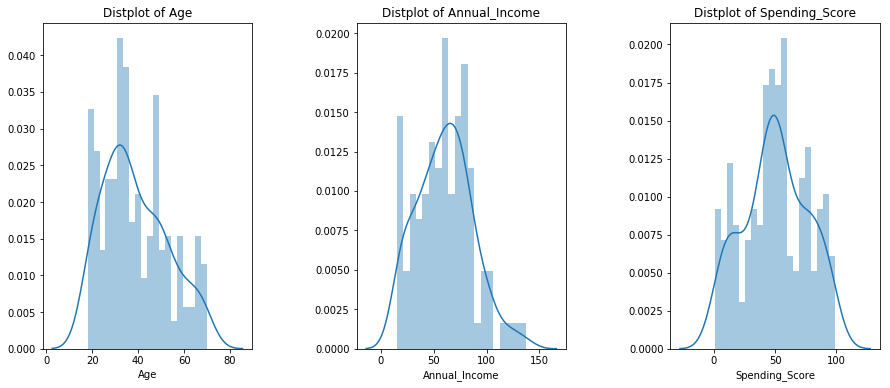

In [84]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age' , 'Annual_Income' , 'Spending_Score']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

From the histogram plots we see that the dependent variables and independent variables are normally distributed. Therefore, we can use OLS regression analysis on this data.

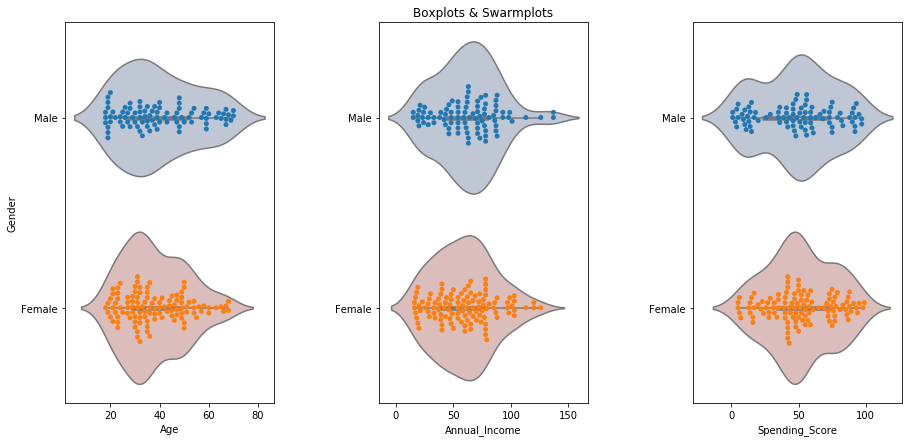

In [85]:
plt.figure(1 , figsize = (15 , 7))
n = 0 
for cols in ['Age' , 'Annual_Income' , 'Spending_Score']:
    n += 1 
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.violinplot(x = cols , y = 'Gender' , data = df , palette = 'vlag')
    sns.swarmplot(x = cols , y = 'Gender' , data = df)
    plt.ylabel('Gender' if n == 1 else '')
    plt.title('Boxplots & Swarmplots' if n == 2 else '')
plt.show()

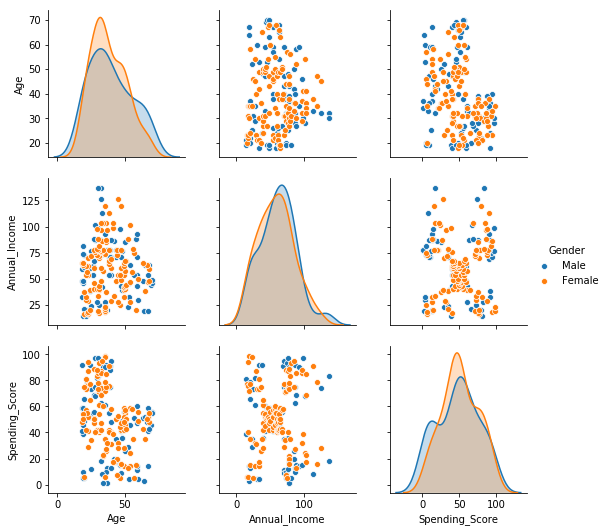

In [86]:
sns.pairplot(df,hue='Gender')

We see that Age, Annual Income are not colinear. The corelation between the spending score, age and annual income are low.

In [87]:
result = smf.ols(formula='Spending_Score ~ Annual_Income + Age + Gender-1', data=df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Spending_Score   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     7.960
Date:                Sun, 28 Jul 2019   Prob (F-statistic):           4.91e-05
Time:                        17:01:30   Log-Likelihood:                -922.05
No. Observations:                 200   AIC:                             1852.
Df Residuals:                     196   BIC:                             1865.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Gender[Female]    73.9300      6.642     11.130      0.000      60.831      87.029
Gender[Male]      71.9168      7.023     10.240      0.000      58.067      85.767
Annual_Income      0.0079      0.066      0.119      0.905      -0.123       0.139
Age               -0.6004      0.125     -4.806      0.000      -0.847      -0.354
==============================================================================
Omnibus:                       11.059   Durbin-Watson:                   3.448
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                6.033
Skew:                          -0.233   Prob(JB):                       0.0490
Kurtosis:                       2.288   Cond. No.                         407.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see a low R-squared value of 0.697. p-value for GenderGroup is high (>0.05) showing that it is not a significant factor for the change in spending score. We can drop GenderGroup from our model.

##### Age Grouping:
We will divide the data into the age groups, and try to run regression analysis for each age group. We do this to find out which age groups has more significant effect on the spending score.

In [93]:
bins = [0,25,35,45,55,65,100]
agegroup = ['Below 25','26 - 35','36 - 45','46 - 55','56 - 65','Above 66']
df['AgeGroup'] = pd.cut(df['Age'],bins=bins,labels=agegroup)
df['GenderGroup'] = df['Gender'].apply(lambda x: 1 if x =='Male' else 0)

In [94]:
df.head()

,Gender,Age,Annual_Income,Spending_Score,AgeGroup,GenderGroup
0,Male,19,15,39,Below 25,1
1,Male,21,15,81,Below 25,1
2,Female,20,16,6,Below 25,0
3,Female,23,16,77,Below 25,0
4,Female,31,17,40,26 - 35,0


#### Model Building
We apply forward elimination to select the combination of independant variables that will result in the highest R-squared.

Forward selection, which involves starting with no variables in the model, testing the addition of each variable using a chosen model fit criterion, adding the variable (if any) whose inclusion gives the most statistically significant improvement of the fit, and repeating this process until none improves the model to a statistically significant extent.

In [89]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} - 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} - 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model


##### Running our Regression Model based on the selected combination from forward elimination on 6 indivdual age groups: 'Below 25','26 - 35','36 - 45','46 - 55','56 - 65','Above 66' to find the best fit model.

### Predicted Spending Score VS Actual Spending Score

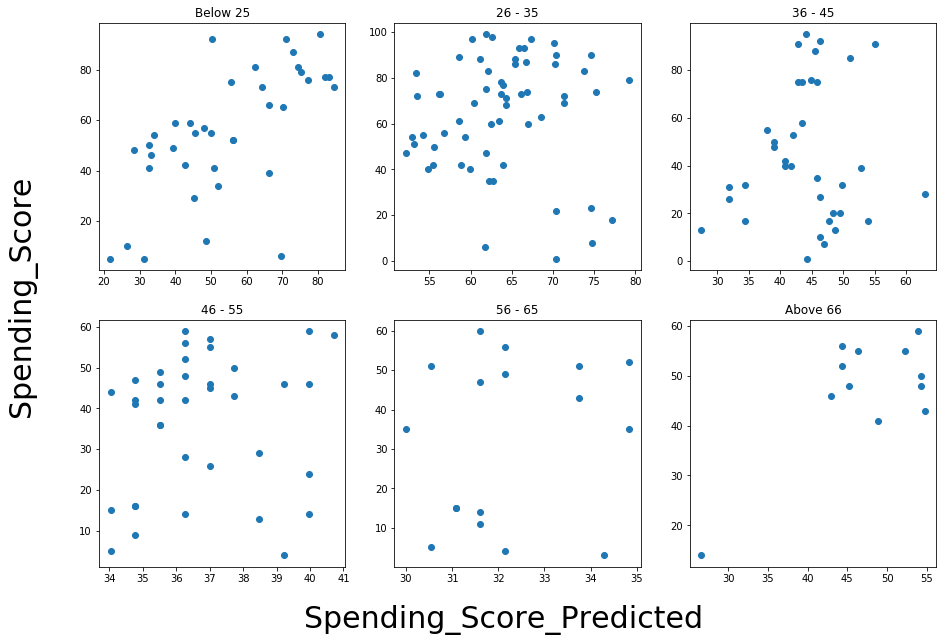

In [107]:
result_Tval = []
result_RS = []
result_para = []
df_orginal = pd.DataFrame()
fig, axs = plt.subplots(2,3,figsize=(15,10))
fig.text(0.5, 0.04, 'Spending_Score_Predicted', ha='center',size=30)
fig.text(0.04, 0.5, 'Spending_Score', va='center', rotation='vertical',size=30)
for i in range(0,len(agegroup)):
    df_temp = df.loc[:,{'Age','Annual_Income','Spending_Score','GenderGroup'}][df.loc[:,'AgeGroup']==agegroup[i]]
    result = forward_selected(df_temp,'Spending_Score')
    result_Tval.append(round(result.pvalues,2))
    result_RS.append(round(result.rsquared_adj,2))
    result_para.append(round(result.params,4))
    df_temp['y_predicted'] = result.predict(df_temp[pd.DataFrame(result.pvalues).index])
    df_temp['residual'] = result.resid
    df_temp['AgeGroup'] = agegroup[i]    
    df_orginal = pd.concat([df_orginal,df_temp])
    if i < 3:
        axs[0][i].scatter(df_temp['y_predicted'],df_temp['Spending_Score'])
        axs[0][i].set_title(agegroup[i])
    else:
        axs[1][i-3].scatter(df_temp['y_predicted'],df_temp['Spending_Score'])
        axs[1][i-3].set_title(agegroup[i])        

Looking at the above plots we can say that the

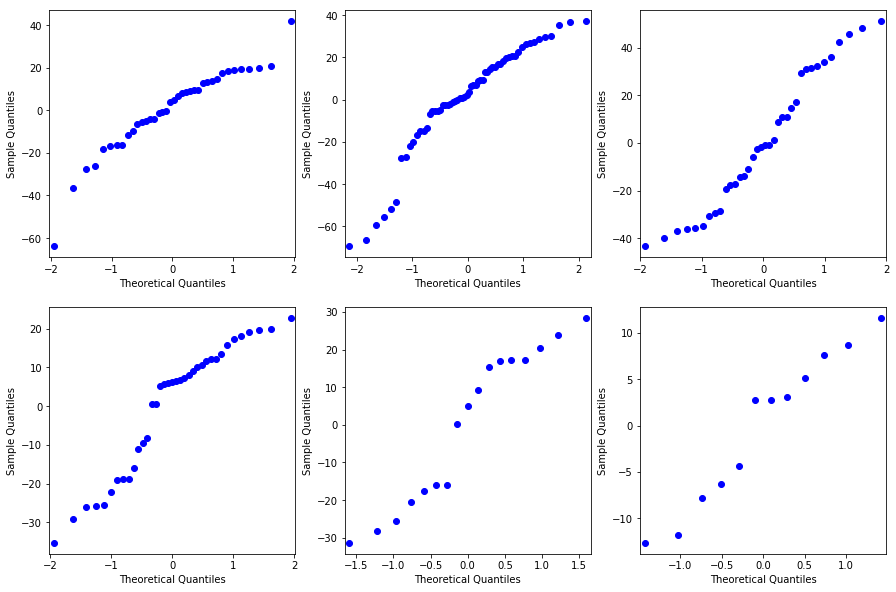

In [108]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i in range(0,len(agegroup)):
    if i < 3:
        sm.qqplot(df_orginal['residual'][df_orginal['AgeGroup']==agegroup[i]],ax=axs[0][i])
    else:
        sm.qqplot(df_orginal['residual'][df_orginal['AgeGroup']==agegroup[i]],ax=axs[1][i-3]) 

From the above we can see that the residuals are along the diagonal, which shows normal distribution of residuals.
The residuals are nearly normally distributed & centered on 0.

In [109]:
result_para

[Age              4.0296
 Annual_Income   -0.6769
 dtype: float64, Age              1.6762
 Annual_Income    0.1718
 dtype: float64, Age              0.5828
 Annual_Income    0.2917
 dtype: float64, Age    0.7401
 dtype: float64, Age    0.5358
 dtype: float64, Annual_Income    0.6344
 Age              0.2173
 dtype: float64]

### Coefficients (Slope) of Age and Annual Income explained:
1. For Age Group Below 25:
    a. 1 unit increase in Age results in 4.0296 unit increase in Spending Score.
    b. 1 unit increase in Annual Income results in 0.6769 unit decrease in Spending Score.
2. For Age Group 26 - 35:
    a. 1 unit increase in Age results in 1.6762 unit increase in Spending Score.
    b. 1 unit increase in Annual Income results in 0.1718 unit increase in Spending Score.
3. For Age Group 36 - 45:
    a. 1 unit increase in Age results in 0.5828 unit increase in Spending Score.
    b. 1 unit increase in Annual Income results in 0.2917 unit increase in Spending Score.
4. For Age Group 46 - 55:
    a. 1 unit increase in Age results in 0.7401 unit increase in Spending Score.
    b. Based on Forward Selection results Annual Income is not used in the model for Age Group 46 - 55.
5. For Age Group 56 - 65:
    a. 1 unit increase in Age results in 0.5358 unit increase in Spending Score.
    b. Based on Forward Selection results Annual Income is not used in the model for this age group.
6. For Age Group Above 65:
    a. 1 unit increase in Age results in 0.2173 unit increase in Spending Score.
    b. 1 unit increase in Annual Income results in 0.6344 unit increase in Spending Score.

Apply linear multivariate regression on age group, to select the combination age and annual income that would yield the highest R-square

In [110]:
result_Tval

[Age              0.0
 Annual_Income    0.0
 dtype: float64, Age              0.00
 Annual_Income    0.11
 dtype: float64, Age              0.13
 Annual_Income    0.15
 dtype: float64, Age    0.0
 dtype: float64, Age    0.0
 dtype: float64, Annual_Income    0.01
 Age              0.19
 dtype: float64]

### T-Value Explained:
1. For Age Group Below 25: 
    T-Value for Age is 0.0 (lower than 0.05, thus statistically significant)
    T-Value for Annual Income is 0.0 (lower than 0.05, thus statistically significant)
2. For Age Group 26 - 35:
    T-Value for Age is 0.00 (lower than 0.05, thus statistically significant)
    T-Value for Annual Income is 0.11 (Statistically insignificant)
3. For Age Group 36 - 45:
    T-Value for Age is 0.13 (Statistically insignificant)
    T-Value for Annual Income is 0.15 (Statistically insignificant)
4. For Age Group 46 - 55:
    T-Value for Age is 0.00 (lower than 0.05, thus statistically significant)
    Annual Income is not considered in the model.
5. For Age Group 56 - 65:
    T-Value for Age is 0.00 (lower than 0.05, thus statistically significant)
    T-Value for Annual Income is 0.01 (lower than 0.05, thus statistically significant)
6. For Age Group Above 65:
    T-Value for Age is 0.01 (lower than 0.05, thus statistically significant)
    T-Value for Annual Income is 0.19 (Statistically insignificant)

In [111]:
result_RS

[0.89, 0.86, 0.7, 0.83, 0.71, 0.97]

### R-Squared Explained:
1. For Age Group Below 25: R-squared value is 0.89.
    89% change in spending score can be explained by the regression model using Age and Annual Income as the dependent variables.
2. For Age Group 26 - 35: R-squared value is 0.86.
    86% change in spending score can be explained by the regression model using Age and Annual Income as the dependent variables.
3. For Age Group 36 - 45: R-squared value is 0.7.
    70% change in spending score can be explained by the regression model using Age and Annual Income as the dependent variables.
4. For Age Group 46 - 55: R-squared value is 0.83.
    83% change in spending score can be explained by the regression model using Age as the dependent variables.
5. For Age Group 56 - 65: R-squared value is 0.71.
    71% change in spending score can be explained by the regression model using Age as the dependent variables.
6. For Age Group Above 65: R-squared value is 0.97.
    97% change in spending score can be explained by the regression model using Age and Annual Income as the dependent variables.

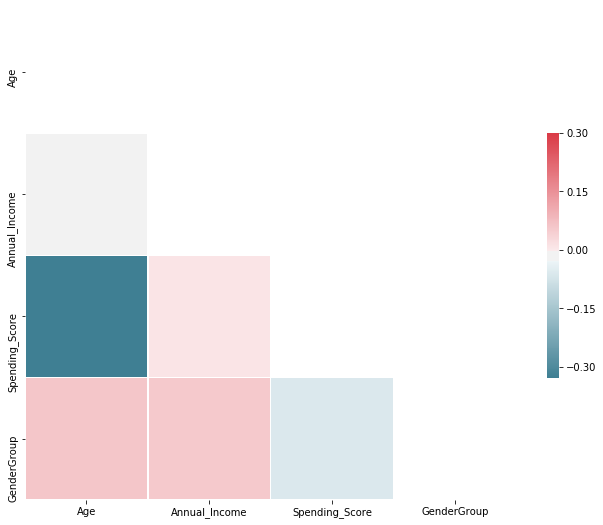

In [112]:
import seaborn

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

In [113]:
X = df.loc[:,['Age','Annual_Income']]
Y = df.loc[:,['Spending_Score']]

with pm.Model() as linear_model:
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    slope = pm.Normal('slope', mu = 0, sd = 10)
    
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate
    mean = intercept + slope * X
    
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = Y.values)
    
    #Sampler
    step = pm.NUTS()
    
    linear_trace = pm.sample(20000, step=step, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, Intercept]
Sampling 2 chains: 100%|██████████| 41000/41000 [00:52<00:00, 780.44draws/s]


In [114]:
linear_trace.mean_tree_accept.mean()

0.8677513641821076

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c26f4e710>,
      dtype=object)

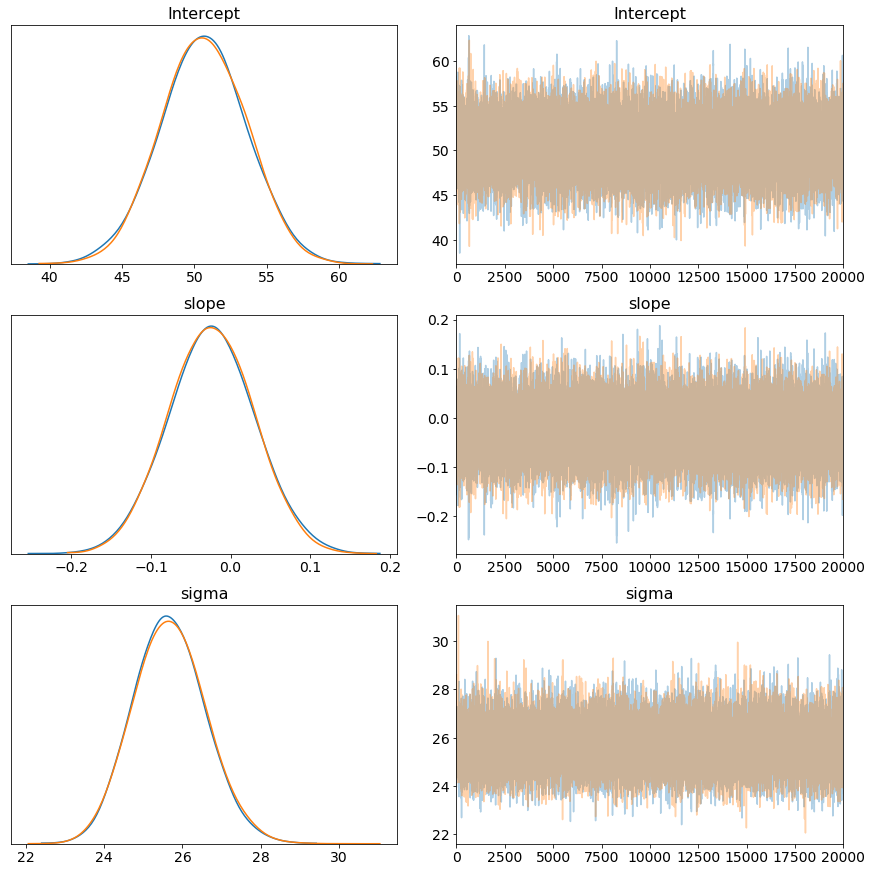

In [115]:
pm.traceplot(linear_trace, figsize=(12,12))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ce23978>,
      dtype=object)

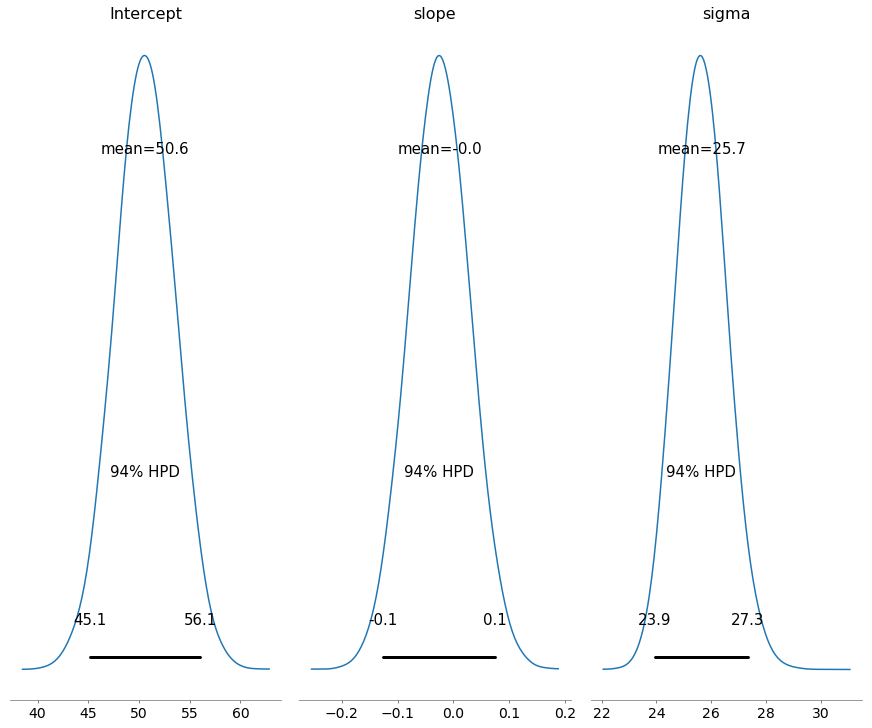

In [116]:
pm.plot_posterior(linear_trace, figsize=(12,10), text_size=20)

In [117]:
from sklearn.linear_model import LinearRegression

lin_reg=LinearRegression()

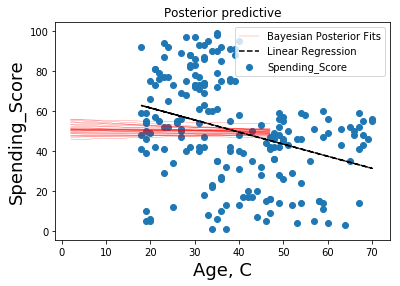

In [118]:
lin_reg.fit(X.Age.values.reshape(-1, 1), Y)
pm.plot_posterior_predictive_glm(linear_trace, eval=np.linspace(2,47, 100), 
                                 color='red', label = 'Bayesian Posterior Fits',
                                 lm= lambda x, sample:
                                 sample['Intercept'] + sample['slope']*x)

plt.plot(X.Age.values.reshape(-1, 1), lin_reg.predict(X.Age.values.reshape(-1, 1)), 'k--', label='Linear Regression')
plt.scatter(x=df["Age"], y=df["Spending_Score"])
plt.ylabel('Spending_Score', size = 18)
plt.xlabel('Age, C', size = 18)
plt.legend()

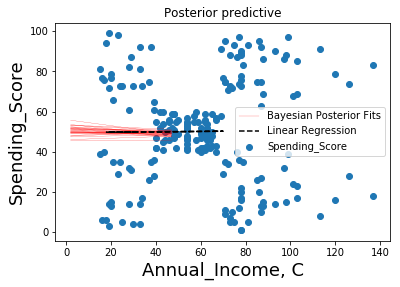

In [119]:
lin_reg.fit(X.Annual_Income.values.reshape(-1, 1), Y)
pm.plot_posterior_predictive_glm(linear_trace, eval=np.linspace(2,47, 100), 
                                 color='red', label = 'Bayesian Posterior Fits',
                                 lm= lambda x, sample:
                                 sample['Intercept'] + sample['slope']*x)

plt.plot(X.Age.values.reshape(-1, 1), lin_reg.predict(X.Age.values.reshape(-1, 1)), 'k--', label='Linear Regression')
plt.scatter(x=df["Annual_Income"], y=df["Spending_Score"])
plt.ylabel('Spending_Score', size = 18)
plt.xlabel('Annual_Income, C', size = 18)
plt.legend()

In [120]:
pm.summary(linear_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,50.595077,2.924561,0.023820,45.060437,56.473712,16267.947782,0.999985
slope,-0.024817,0.053424,0.000438,-0.127475,0.081428,16387.961587,0.999995
sigma,25.660365,0.907729,0.006453,23.925878,27.460688,22442.836993,1.000063
